In [40]:
import os 
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
%matplotlib inline

In [27]:
df= pd.read_csv("american_train_28.csv")

In [28]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,A,255,244,252,254,253,237,236,131,91,...,159,159,149,138,135,138,124,128,114,110
1,A,96,31,30,27,24,17,10,12,15,...,151,143,198,199,199,198,196,191,190,188
2,A,61,15,13,11,12,17,38,0,0,...,233,223,243,250,253,250,253,253,253,252
3,A,233,220,225,226,229,207,193,60,46,...,109,107,102,95,88,84,81,81,70,73
4,A,63,16,14,12,11,21,44,0,0,...,231,239,244,249,252,252,252,252,252,252


In [29]:
# separamos en conjunto de entrenamiento y de prueba
X = df.drop('label',axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,255,244,252,254,253,237,236,131,91,84,...,159,159,149,138,135,138,124,128,114,110
1,96,31,30,27,24,17,10,12,15,8,...,151,143,198,199,199,198,196,191,190,188
2,61,15,13,11,12,17,38,0,0,8,...,233,223,243,250,253,250,253,253,253,252
3,233,220,225,226,229,207,193,60,46,41,...,109,107,102,95,88,84,81,81,70,73
4,63,16,14,12,11,21,44,0,0,9,...,231,239,244,249,252,252,252,252,252,252


In [31]:
from sklearn.preprocessing import LabelBinarizer
# convertimos las etiquetas a números 
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [33]:
# Normalizamos los datos
X_train = X_train / 255.0
X_test = X_test / 255.0

In [35]:
# Aplicamos reshape para que las imágenes tengan 3 dimensiones
x_train = X_train.values.reshape(-1,28,28,1)
x_test = X_test.values.reshape(-1,28,28,1)

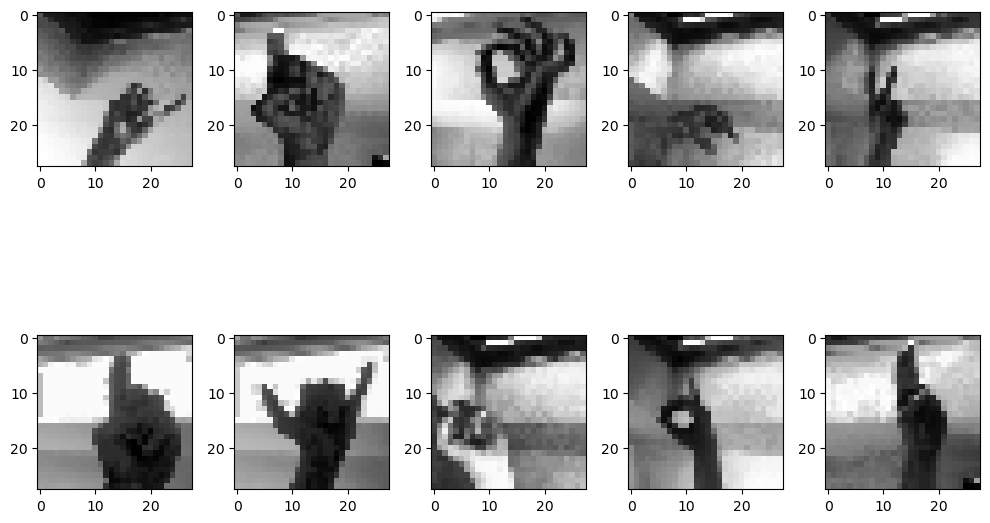

In [36]:
# Preview de 10 imágenes aleatorias
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    


In [37]:
# Preparamos el modelo
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [38]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [42]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 29 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 75)       300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 75)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 50)      

In [43]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20


2022-11-26 14:14:25.030521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


181/182 [============================>.] - ETA: 0s - loss: 2.1241 - accuracy: 0.3698

2022-11-26 14:14:30.797782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 8s 34ms/step - loss: 2.1194 - accuracy: 0.3710 - val_loss: 4.3460 - val_accuracy: 0.0359 - lr: 0.0010
Epoch 2/20
182/182 [==============================] - 5s 28ms/step - loss: 1.0031 - accuracy: 0.6733 - val_loss: 3.3161 - val_accuracy: 0.1488 - lr: 0.0010
Epoch 3/20
182/182 [==============================] - 5s 28ms/step - loss: 0.6202 - accuracy: 0.7979 - val_loss: 1.3701 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 4/20
182/182 [==============================] - 5s 28ms/step - loss: 0.4637 - accuracy: 0.8459 - val_loss: 0.4545 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 5/20
182/182 [==============================] - 5s 28ms/step - loss: 0.3587 - accuracy: 0.8796 - val_loss: 0.9366 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 6/20
182/182 [==============================] - 5s 28ms/step - loss: 0.3032 - accuracy: 0.8970 - val_loss: 0.3821 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/20
182/182 [==============================] - 5s 28ms/step - loss: 

In [45]:
# A continuacion, tenemos que crear un archivo de etiquetas que contendra todas nuestras etiquetas (importante para Flutter)
labels = '\n'.join(sorted(df.label.unique()))
with open('labels.txt', 'w') as f: # escribe en el archivo labels.txt, y si no existe, lo crea, y si existe, lo sobreescribe. (eso es lo que 'w' es para)
    f.write(labels)

In [46]:
# con nuestra red neuronal entrenada con tensorflow y keras, podemos exportarla
saved_model_dir = '' # directorio donde se guardara el modelo
tf.saved_model.save(model, saved_model_dir) # guarda el modelo en el directorio

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert() # convierte el modelo en un modelo de tensorflow lite, que pueda usar flutter 
with open('model.tflite', 'wb') as f: # guardamos el modelo en un archivo llamado model.tflite, y si no existe, lo crea, y si existe, lo sobreescribe. (eso es lo que 'wb' es para)
  f.write(tflite_model)

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: /var/folders/w9/47hfrj5s20n22dxytnnn2mjh0000gn/T/tmpasu6eyx7/assets


INFO:tensorflow:Assets written to: /var/folders/w9/47hfrj5s20n22dxytnnn2mjh0000gn/T/tmpasu6eyx7/assets
2022-11-26 14:18:07.203040: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-26 14:18:07.203054: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-26 14:18:07.203736: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/w9/47hfrj5s20n22dxytnnn2mjh0000gn/T/tmpasu6eyx7
2022-11-26 14:18:07.205912: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-26 14:18:07.205919: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/w9/47hfrj5s20n22dxytnnn2mjh0000gn/T/tmpasu6eyx7
2022-11-26 14:18:07.210793: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-26 14:18:07.212548: I tensorflow/cc/saved_model/load

In [50]:
# Cargamos el modelo en memoria 
path = 'model.tflite' # ruta del modelo
interpreter = tf.lite.Interpreter(model_path=path) 
interpreter.allocate_tensors()

In [47]:
def image_processing_as_array(file_path):
    # Leemos la imagen
    hand_img = cv2.imread(file_path)
    # Procesamos la imagen
    # 1. Convertir a escala de grises
    img_gray = cv2.cvtColor(hand_img, cv2.COLOR_BGR2GRAY)
    # 3. Darle un contraste
    img_gray = cv2.equalizeHist(img_gray)
    # 4. Darle la vuelta a la imagen
    img_gray = cv2.flip(img_gray, 1)
    # 5. Escalar la imagen
    img_gray = cv2.resize(img_gray, (28, 28))
    # 6. Convertir a un array
    img_gray = np.array(img_gray).reshape(-1)
    # 7. Normalizar los datos
    img_gray = img_gray / 255.0
    # 8. Convertir a un array de 3 dimensiones
    img_gray = img_gray.reshape(-1, 28, 28, 1)
    return img_gray

In [55]:
# cargamos la imagen
path = 'dataset/asl_alphabet_test/asl_alphabet_test/space_test.jpg' # ruta de la imagen
img_array = image_processing_as_array(path)

# predecimos la imagen 
input_details = interpreter.get_input_details() # obtenemos los detalles de la entrada
output_details = interpreter.get_output_details() # obtenemos los detalles de la salida

# convertimos a float32
input_shape = input_details[0]['shape']
input_data = np.array(img_array, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke() # invocamos el modelo
output_data = interpreter.get_tensor(output_details[0]['index']) # obtenemos la salida
# print(output_data) # imprimimos la salida

# obtenemos la etiqueta de la prediccion
with open('labels.txt', 'r') as f:
    labels = [line.strip() for line in f.readlines()]
prediction = np.argmax(output_data) # obtenemos el indice de la prediccion
print(labels[prediction]) # imprimimos la etiqueta de la prediccion


SPACE
